## Import libraries

In [18]:
import numpy as np
import scipy.sparse
import pandas as pd
import random

## Initialiaze Weights and random X, epsilon and generate labels Y

In [19]:
n = 250
d = 80
k = 10
mu = 0
sigma = 1

In [20]:
X = []
for i in range(n):
    X.append(np.random.normal(mu, sigma, d))
X = scipy.sparse.csr_matrix(X).T
B_star = np.zeros(n)
w_star = np.random.rand(d)
for i in range(k):
    w_star[i] = random.choice([10, -10]) 
w_star[k:] = 0
eps = np.random.normal(mu, sigma, n)

In [21]:
Y = X.T.dot(w_star) + B_star + eps

In [22]:
w = np.random.rand(d)
B = np.zeros(n)

## Define lambda_max, loss, rmse and train functions

In [23]:
def init_lambda(X, Y):
    return 2 * max(abs(X.dot(Y - sum(Y)/len(Y))))

In [24]:
def loss(X, Y, w, B, lam):
    err = Y - X.T.dot(w) - B
    err = np.square(err)
    loss_val = sum(err) + lam * sum(abs(w))
    return loss_val

In [25]:
from math import sqrt
def rmse(actual, pred):
    new = actual - pred
    new = np.square(new)
    new = sum(new)
    new /= len(actual)
    return sqrt(new)

In [26]:
def train(X, Y, w, B, lam, delta):
    A_k = 2 * (np.square(X.todense()).sum(axis = 1))
    A_k = np.squeeze(np.asarray(A_k))
    prev_loss = float('inf')
    loss_val = 0
    while prev_loss - loss_val > delta:
        R = Y - X.T.dot(w) - B
        Bold = B.copy()
        B = float(1/len(Y)) * sum(R + B)
        B = np.full(len(Y), B)
        R = R + Bold - B
        for k in range(len(w)):
            c_k = 2 * (X[k].dot(np.reshape(R, (-1, 1)) + w[k]*(X[k].T)))
            c_k = c_k.item((0,0))
            tmp = w[k]
            if c_k < -lam:
                w[k] = (c_k + lam) / A_k[k]
            elif -lam <= c_k <= lam:
                w[k] = 0
            elif c_k > lam:
                w[k] = (c_k - lam) / A_k[k]
            R = np.reshape(R, (-1, 1)) - (X[k].T * (w[k] - tmp))
        R = np.squeeze(np.asarray(R))
        if loss_val:
            prev_loss = loss_val
        loss_val = loss(X, Y, w, B, lam)
        print(loss_val)
    return w, B

## Calculate precision, recall and train rmse for 10 iterations

In [27]:
new_w, new_b = w, B
lam = init_lambda(X, Y)
delta = 0.0001
lambda_val = []
rmse_train = []
prec = []
rec = []
# rmse_cv = []
# non_zero = []
# param_list = []
for j in range(10):
    rmse_train.append(rmse(Y, X.T.dot(new_w) + new_b))
    print("Iteration: ", j + 1)
    print("RMSE_ TRAIN = ", rmse_train[-1])
#     print("RMSE_CV = ", rmse_cv[-1])
    print("==========================new lambda==============================")
    print("Lambda = ", lam)
    lambda_val.append(lam)
#     non_zero.append(np.count_nonzero(new_w))
#     rmse_cv.append(rmse(Y_cv, X_cv.T.dot(new_w) + new_b))
#     optimal_w, optimal_b = new_w.copy(), new_b.copy()
    new_w, new_b = train(X, Y, new_w, new_b, lam, delta)
    if not np.count_nonzero(new_w):
        prec.append(1)
    else:
        prec.append(np.count_nonzero(new_w[:k]) / np.count_nonzero(new_w))
    rec.append(np.count_nonzero(new_w[:k])/ k)
    print("PREC/REC :", prec[-1], rec[-1])
    lam /= 2


Iteration:  1
RMSE_ TRAIN =  28.810042706729778
==========================new lambda==============================
Lambda =  5684.04370497
199907.191807
199836.639577
199836.564213
199836.564201
PREC/REC : 1.0 0.1
Iteration:  2
RMSE_ TRAIN =  28.272712110955514
==========================new lambda==============================
Lambda =  2842.02185248
177503.528173
177153.05637
177149.890145
177149.866632
177149.866605
PREC/REC : 1.0 0.9
Iteration:  3
RMSE_ TRAIN =  20.641955097018403
==========================new lambda==============================
Lambda =  1421.01092624
117022.366941
115404.277897
115372.534021
115371.973467
115371.962753
115371.962548
115371.962544
PREC/REC : 1.0 1.0
Iteration:  4
RMSE_ TRAIN =  10.375599400572703
==========================new lambda==============================
Lambda =  710.505463121
64887.1907181
64480.0024903
64472.0054646
64471.8641872
64471.8614867
64471.861435
PREC/REC : 1.0 1.0
Iteration:  5
RMSE_ TRAIN =  5.254004068140169
===============

In [28]:
np.count_nonzero(new_w)

59

## Plot precision and recall values against lambda

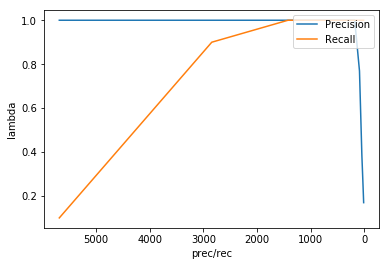

In [29]:
import matplotlib.pyplot as plt
plt.plot(lambda_val, prec)
plt.plot(lambda_val, rec)
plt.ylabel('lambda')
plt.xlabel('prec/rec')
ax = plt.gca()
ax.invert_xaxis()
plt.legend(['Precision', 'Recall'], loc='upper right')
plt.show()

In [30]:
precision = np.count_nonzero(new_w[:k]) / np.count_nonzero(new_w)
recall = np.count_nonzero(new_w[:k])/ k
print(precision, recall)

0.1694915254237288 1.0


## Define lambda finding function for optimal lambda

In [31]:
def find_lam(lam, w, B, X, Y):
    new_w, new_b = w, B
#     lam = init_lambda(X, Y)
    delta = 0.0001
#     lambda_val = []
    rmse_train = []
#     prec = []
#     rec = []
    # rmse_cv = []
    # non_zero = []
    # param_list = []
    prev_rmse = float('inf')
    curr_rmse = 0
    while prev_rmse - curr_rmse > 0.0001:
        rmse_train.append(rmse(Y, X.T.dot(new_w) + new_b))
#         print("Iteration: ", j + 1)
        print("RMSE_ TRAIN = ", rmse_train[-1])
    #     print("RMSE_CV = ", rmse_cv[-1])
        print("==========================new lambda==============================")
        print("Lambda = ", lam)
        lambda_val.append(lam)
    #     non_zero.append(np.count_nonzero(new_w))
    #     rmse_cv.append(rmse(Y_cv, X_cv.T.dot(new_w) + new_b))
    #     optimal_w, optimal_b = new_w.copy(), new_b.copy()
        new_w, new_b = train(X, Y, new_w, new_b, lam, delta)
        if not np.count_nonzero(new_w):
            prec.append(1)
        else:
            prec.append(np.count_nonzero(new_w[:k]) / np.count_nonzero(new_w))
        rec.append(np.count_nonzero(new_w[:k])/ k)
        print("PREC/REC :", prec[-1], rec[-1])
        if curr_rmse:
            prev_rmse = curr_rmse
        curr_rmse = rmse(Y, X.T.dot(new_w) + new_b)
        lam /= 2
    return lam * 2

## Get optimal lambda

In [32]:
opt_lam = find_lam(init_lambda(X, Y), w, B, X, Y)
print(opt_lam)


RMSE_ TRAIN =  0.815667681207309
==========================new lambda==============================
Lambda =  5684.04370497
199970.761113
199836.564201
199836.564201
PREC/REC : 1 0.0
RMSE_ TRAIN =  28.272712229379387
==========================new lambda==============================
Lambda =  2842.02185248
177503.528183
177153.05637
177149.890145
177149.866632
177149.866605
PREC/REC : 1.0 0.9
RMSE_ TRAIN =  20.64195509701807
==========================new lambda==============================
Lambda =  1421.01092624
117022.366941
115404.277897
115372.534021
115371.973467
115371.962753
115371.962548
115371.962544
PREC/REC : 1.0 1.0
RMSE_ TRAIN =  10.375599400572701
==========================new lambda==============================
Lambda =  710.505463121
64887.1907181
64480.0024903
64472.0054646
64471.8641872
64471.8614867
64471.861435
PREC/REC : 1.0 1.0
RMSE_ TRAIN =  5.254004068140169
==========================new lambda==============================
Lambda =  355.252731561
34122.602078

In [34]:
opt_lam

0.17346324783229664

## Generate new train data and epsilon with sigma = 10 and get the labels

In [35]:
sigma_new = 10
X_2 = []
for i in range(n):
    X_2.append(np.random.normal(mu, sigma_new, d))
X_2 = scipy.sparse.csr_matrix(X_2).T
eps_2 = np.random.normal(mu, sigma_new, n)

In [36]:
Y_2 = X_2.T.dot(w_star) + B_star + eps_2

## Train over the optimal lambda and previous parameters 

In [1]:
new_w_2, new_b_2 = new_w.copy(), new_b.copy()
# lam = init_lambda(X, Y)
delta = 0.0001
# lambda_val = []
rmse_train_2 = []
prec_2 = []
rec_2 = []
# rmse_cv = []
# non_zero = []
# param_list = []
for j in range(20):
    rmse_train_2.append(rmse(Y_2, X_2.T.dot(new_w_2) + new_b_2))
    print("Iteration: ", j + 1)
    print("RMSE_ TRAIN = ", rmse_train_2[-1])
#     print("RMSE_CV = ", rmse_cv[-1])
    print("==========================new lambda==============================")
    print("Lambda = ", opt_lam)
#     lambda_val.append(lam)
#     non_zero.append(np.count_nonzero(new_w))
#     rmse_cv.append(rmse(Y_cv, X_cv.T.dot(new_w) + new_b))
#     optimal_w_2, optimal_b_2 = new_w_2.copy(), new_b_2.copy()
    new_w_2, new_b_2 = train(X, Y, new_w_2, new_b_2, opt_lam, delta)
    if not np.count_nonzero(new_w_2):
        prec_2.append(1)
    else:
        prec_2.append(np.count_nonzero(new_w_2[:k]) / np.count_nonzero(new_w_2))
    rec_2.append(np.count_nonzero(new_w_2[:k])/ k)
    print("PREC/REC :", prec_2[-1], rec_2[-1])
        

NameError: name 'new_w' is not defined

## Plot new precision and old precision values

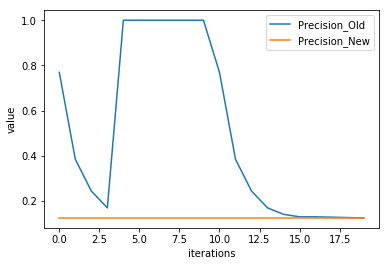

In [61]:
import matplotlib.pyplot as plt
plt.plot(range(len(prec[-20:])), prec[-20:])
plt.plot(range(len(prec[-20:])), prec_2)
plt.ylabel('value')
plt.xlabel('iterations')
# ax = plt.gca()
# ax.invert_xaxis()
plt.legend(['Precision_Old', 'Precision_New'], loc='upper right')
plt.show()

## Plot new recall and old recall values

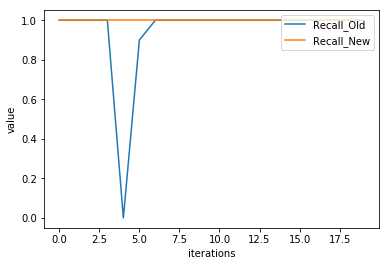

In [59]:
import matplotlib.pyplot as plt
plt.plot(range(len(rec[-20:])), rec[-20:])
plt.plot(range(len(rec[-20:])), rec_2)
plt.ylabel('value')
plt.xlabel('iterations')
# ax = plt.gca()
# ax.invert_xaxis()
plt.legend(['Recall_Old', 'Recall_New'], loc='upper right')
plt.show()

In [38]:
np.count_nonzero(new_w)

80

In [37]:
precision_2 = np.count_nonzero(new_w_2[:k]) / np.count_nonzero(new_w_2)
recall_2 = np.count_nonzero(new_w_2[:k])/ k
print(precision_2, recall_2)

0.12658227848101267 1.0
